* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

# model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
# model1.objective = "EX_glc__D_e" 



In [2]:
# glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 2.6619851, 3.1] # the fifth glc uptake value was calculated
growth_rates = [0.049, 0.100, 0.151, 0.203, 0.25, 0.301]

# medium = model.medium
# medium["EX_glc__D_e"] = glucose_uptakes[3]
# model.medium = medium
# solution = model1.optimize()

In [3]:
# all_fluxes = solution.fluxes
# all_fluxes

In [4]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_l', 'nadph_m', 'nadph_r', 'nadph_rm','nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r', 'nadh_rm']
atps = ['atp_c', 'atp_m', 'atp_n', 'atp_r', 'atp_en', 'atp_gm', 'atp_l', 'atp_rm', 'atp_vm', 'atp_x'] 


In [5]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, growth_rate):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    
    model.reactions.EX_glc__D_e.bounds = -9999, 9999
    model.reactions.BIOMASS_RT_CLIM.bounds = growth_rate, growth_rate
    
    model.objective = "EX_glc__D_e"
    solution = model.optimize()

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

In [6]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold): # threshold shows the percent of the flux for including in others sector on pie chart 
    import plotly.graph_objects as go
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    model.objective = "EX_glc__D_e"
    solution = model.optimize()  
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), getattr(model.reactions, reaction).name, str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other producing', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other consuming', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(title)
    plt.show()  
    
    return pie_chart

In [7]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, growth_rates[0])
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, growth_rates[5])
nadph_fluxes_highest_GR


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21
SUM produced: 0.7880266257042259, SUM consumed: -0.7880266257252327
SUM produced: 4.840734986468736, SUM consumed: -4.840734986448156


,flux,reaction,percent
G6PDH2i_c,2.170452,G6PDH2i_c,0.448372
GND_c,2.170452,GND_c,0.448372
ME2_m,0.311721,ME2_m,0.064395
MTHFD_c,0.095944,MTHFD_c,0.019820
MTHFD_m,0.037127,MTHFD_m,0.007670
...,...,...,...
AGPRi_m,-0.096182,AGPRi_m,0.019869
ASAD_c,-0.150000,ASAD_c,0.030987
KARA1i_m,-0.182575,KARA1i_m,0.037716
HMGCOAR_c,-0.538658,HMGCOAR_c,0.111276


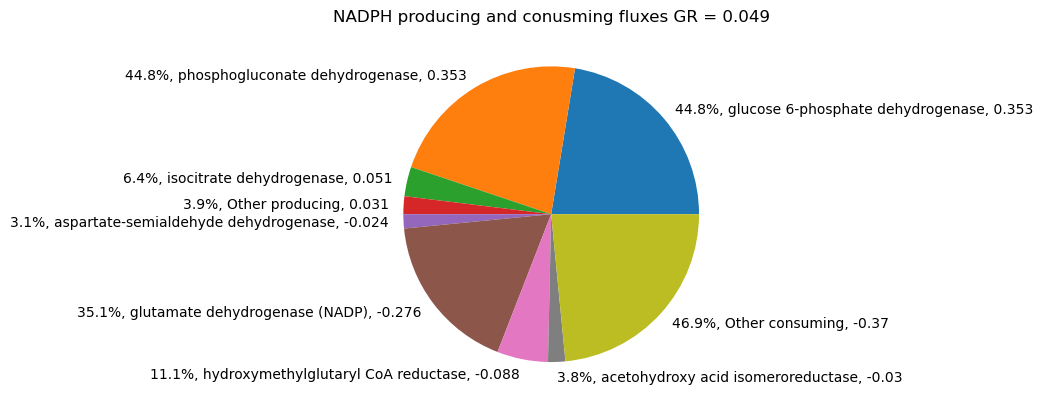

([<matplotlib.patches.Wedge at 0x2580d52b740>,
 [Text(0.8382701702188886, 0.7122521475721892, '44.8%, glucose 6-phosphate dehydrogenase, 0.353'),
  Text(-0.5675383395259054, 0.9422845818372378, '44.8%, phosphogluconate dehydrogenase, 0.353'),
  Text(-1.0727054210139169, 0.2435222366178409, '6.4%, isocitrate dehydrogenase, 0.051'),
  Text(-1.0979513554079763, 0.06710306369896989, '3.9%, Other producing, 0.031'),
  Text(-1.0986972034484488, -0.05352060476637399, '3.1%, aspartate-semialdehyde dehydrogenase, -0.024'),
  Text(-0.8767111768162231, -0.6643624857301272, '35.1%, glutamate dehydrogenase (NADP), -0.276'),
  Text(-0.21467273155073704, -1.0788492101904443, '11.1%, hydroxymethylglutaryl CoA reductase, -0.088'),
  Text(0.04137142003095354, -1.099221727225505, '3.8%, acetohydroxy acid isomeroreductase, -0.03'),
  Text(0.8145619661340849, -0.7392488101632454, '46.9%, Other consuming, -0.37')])

In [8]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[0]}'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold)
producing_nadph_fluxes_lowest_GR_pie_chart

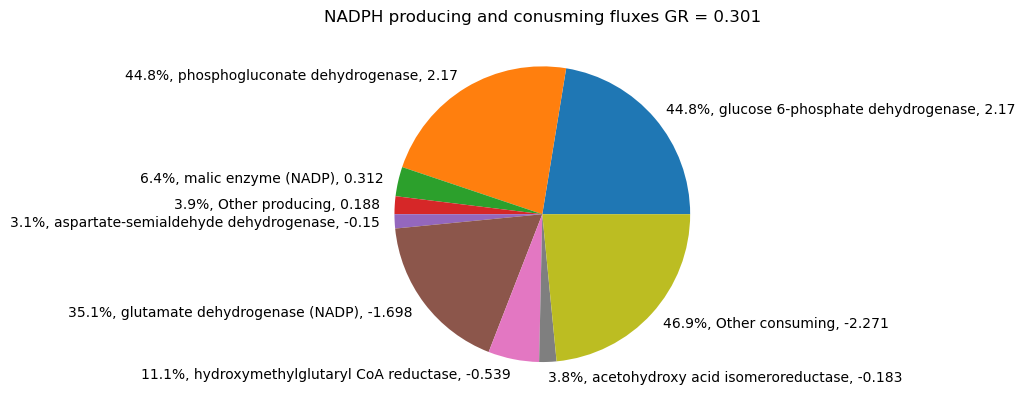

([<matplotlib.patches.Wedge at 0x258027a16d0>,
 [Text(0.8382701702188886, 0.7122521475721892, '44.8%, glucose 6-phosphate dehydrogenase, 2.17'),
  Text(-0.5675383395259054, 0.9422845818372378, '44.8%, phosphogluconate dehydrogenase, 2.17'),
  Text(-1.0727054210139169, 0.2435222366178409, '6.4%, malic enzyme (NADP), 0.312'),
  Text(-1.0979513554079763, 0.06710306369896989, '3.9%, Other producing, 0.188'),
  Text(-1.0986972034484488, -0.05352060476637399, '3.1%, aspartate-semialdehyde dehydrogenase, -0.15'),
  Text(-0.8767111768162231, -0.6643624857301272, '35.1%, glutamate dehydrogenase (NADP), -1.698'),
  Text(-0.21467273155073704, -1.0788492101904443, '11.1%, hydroxymethylglutaryl CoA reductase, -0.539'),
  Text(0.04137142003095354, -1.099221727225505, '3.8%, acetohydroxy acid isomeroreductase, -0.183'),
  Text(0.8145619661340849, -0.7392488101632454, '46.9%, Other consuming, -2.271')])

In [9]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[5]}'
producing_nadph_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title, threshold)
producing_nadph_fluxes_highest_GR_pie_chart

In [10]:
# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, growth_rates[0])
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, growth_rates[5])
nadh_fluxes_highest_GR


SUM produced: 4.15541945556663, SUM consumed: -4.15541945556663
SUM produced: 23.57459793221987, SUM consumed: -23.57459793221987


,flux,reaction,percent
MDH_m,7.997827,MDH_m,0.339256
GAPD_c,5.848614,GAPD_c,0.248090
PDH_m,4.208730,PDH_m,0.178528
ICDHx_m,2.490752,ICDHx_m,0.105654
GCC2c_m,2.132146,GCC2c_m,0.090443
PGCD_c,0.287433,PGCD_c,0.012193
ME1_m,0.153059,ME1_m,0.006493
IPMD_c,0.095319,IPMD_c,0.004043
SACCD2_c,0.078183,SACCD2_c,0.003316
HICITD_m,0.078183,HICITD_m,0.003316


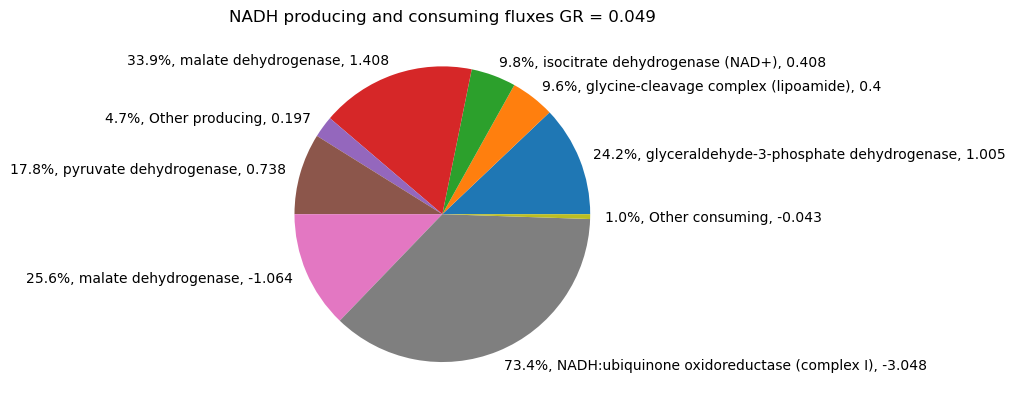

([<matplotlib.patches.Wedge at 0x25810aa8a70>,
 [Text(1.021563712695584, 0.40793085309107757, '24.2%, glyceraldehyde-3-phosphate dehydrogenase, 1.005'),
  Text(0.6741986769574126, 0.869169801585901, '9.6%, glycine-cleavage complex (lipoamide), 0.4'),
  Text(0.38173972613740037, 1.031636942673411, '9.8%, isocitrate dehydrogenase (NAD+), 0.408'),
  Text(-0.3584113987321802, 1.0399717636834387, '33.9%, malate dehydrogenase, 1.408'),
  Text(-0.8872947756840637, 0.6501599657344087, '4.7%, Other producing, 0.197'),
  Text(-1.0574623918975108, 0.30294106641786894, '17.8%, pyruvate dehydrogenase, 0.738'),
  Text(-1.0122174737300862, -0.430599333343054, '25.6%, malate dehydrogenase, -1.064'),
  Text(0.41397659492196215, -1.0191287351737355, '73.4%, NADH:ubiquinone oxidoreductase (complex I), -3.048'),
  Text(1.0998526962366766, -0.018001293867746376, '1.0%, Other consuming, -0.043')])

In [11]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[0]}'
producing_nadh_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

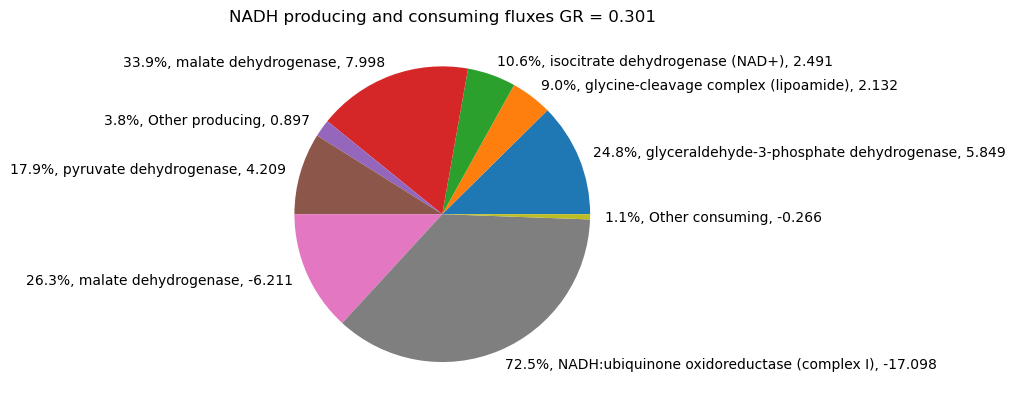

([<matplotlib.patches.Wedge at 0x2580d169b20>,
 [Text(1.017526093786606, 0.417900285311426, '24.8%, glyceraldehyde-3-phosphate dehydrogenase, 5.849'),
  Text(0.665120787124885, 0.8761360274149065, '9.0%, glycine-cleavage complex (lipoamide), 2.132'),
  Text(0.36818903374346684, 1.0365504500172928, '10.6%, isocitrate dehydrogenase (NAD+), 2.491'),
  Text(-0.38498658085084925, 1.0304296834645112, '33.9%, malate dehydrogenase, 7.998'),
  Text(-0.8948830267215492, 0.63967520546421, '3.8%, Other producing, 0.897'),
  Text(-1.0570297202393337, 0.30444731979565176, '17.9%, pyruvate dehydrogenase, 4.209'),
  Text(-1.0071442495846288, -0.44233523545905223, '26.3%, malate dehydrogenase, -6.211'),
  Text(0.42441928660685463, -1.0148242553053848, '72.5%, NADH:ubiquinone oxidoreductase (complex I), -17.098'),
  Text(1.0998272877964517, -0.01949197317618931, '1.1%, Other consuming, -0.266')])

In [12]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[5]}'
producing_nadh_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart


In [13]:
# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, growth_rates[0])
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, growth_rates[5])
atp_fluxes_highest_GR

SUM produced: 12.171081825384022, SUM consumed: -12.171081825394523
SUM produced: 68.32510142575153, SUM consumed: -68.32510142574128


,flux,reaction,percent
ATPS_m,54.918528,ATPS_m,0.803783
PGK_c,5.848614,PGK_c,0.085600
PYK_c,5.409394,PYK_c,0.079171
SUCOAS_m,2.111439,SUCOAS_m,0.030903
FTHFL_m,0.037127,FTHFL_m,0.000543
...,...,...,...
ADK1_c,-1.615474,ADK1_c,0.023644
ACITL_c,-1.660262,ACITL_c,0.024299
PFK_c,-1.904151,PFK_c,0.027869
HEX1_c,-3.968911,HEX1_c,0.058089


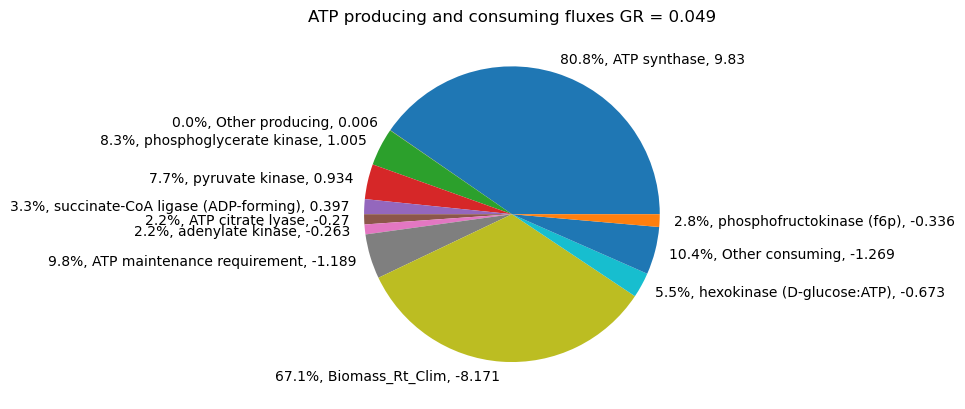

([<matplotlib.patches.Wedge at 0x2580b6ee7b0>,
 [Text(0.32735082931032805, 1.0501625752948163, '80.8%, ATP synthase, 9.83'),
  Text(-0.9056535232215874, 0.6243330007907044, '0.0%, Other producing, 0.006'),
  Text(-0.9791927826890875, 0.5011801016896039, '8.3%, phosphoglycerate kinase, 1.005'),
  Text(-1.0727933728811898, 0.2431344876857265, '7.7%, pyruvate kinase, 0.934'),
  Text(-1.098558856878206, 0.0562888796695178, '3.3%, succinate-CoA ligase (ADP-forming), 0.397'),
  Text(-1.099330856615008, -0.03836232128160379, '2.2%, ATP citrate lyase, -0.27'),
  Text(-1.0940902881162358, -0.11387028343572504, '2.2%, adenylate kinase, -0.263'),
  Text(-1.0537226036099732, -0.3157034599769531, '9.8%, ATP maintenance requirement, -1.189'),
  Text(-0.07880146567295583, -1.097173791615437, '67.1%, Biomass_Rt_Clim, -8.171'),
  Text(0.9647365476647228, -0.5284726990109821, '5.5%, hexokinase (D-glucose:ATP), -0.673'),
  Text(1.0656420095384387, -0.27277666232080483, '10.4%, Other consuming, -1.269'),


In [14]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[0]}'
producing_atp_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

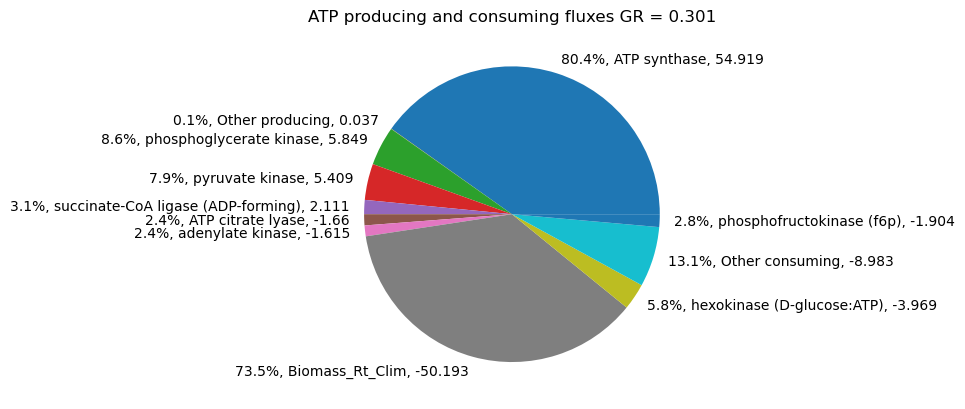

([<matplotlib.patches.Wedge at 0x258160dbda0>,
 [Text(0.33369678370534084, 1.0481633730219306, '80.4%, ATP synthase, 54.919'),
  Text(-0.8980815013093291, 0.6351768391605458, '0.1%, Other producing, 0.037'),
  Text(-0.9755581177034301, 0.5082188101427775, '8.6%, phosphoglycerate kinase, 5.849'),
  Text(-1.0731388845369545, 0.24160491405346288, '7.9%, pyruvate kinase, 5.409'),
  Text(-1.0987042694507472, 0.05337535283911521, '3.1%, succinate-CoA ligase (ADP-forming), 2.111'),
  Text(-1.0991987998890975, -0.041976163740486176, '2.4%, ATP citrate lyase, -1.66'),
  Text(-1.0929250185922985, -0.12455883643894647, '2.4%, adenylate kinase, -1.615'),
  Text(-0.2894068445752789, -1.0612462854177538, '73.5%, Biomass_Rt_Clim, -50.193'),
  Text(0.9129100759773401, -0.6136735232833883, '5.8%, hexokinase (D-glucose:ATP), -3.969'),
  Text(1.0527788833560616, -0.318836357336431, '13.1%, Other consuming, -8.983'),
  Text(1.0989461583035087, -0.048138769717971625, '2.8%, phosphofructokinase (f6p), -1.90

In [15]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[5]}'
producing_atp_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [17]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\iRhto_results\\iRhto_all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[0]}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[5]}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[0]}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[5]}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[0]}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[5]}', index=False)

    